In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd
from cuml.manifold.umap import UMAP as cumlUMAP
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### load data

In [3]:
DATASET_ID = 'mobysound_humpback_whale'
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'humpback.pickle'

In [4]:
syllable_df = pd.read_pickle(df_loc)
del syllable_df['audio']

In [5]:
syllable_df[:3]

,start_time,end_time,SNR,indv,indvi,key,rate,spectrogram
0,15.000000,18.020000,20.783400,UNK,0,940305-0921,4000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,18.680000,25.760000,29.786501,UNK,0,940305-0921,4000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,26.969999,29.389999,33.075901,UNK,0,940305-0921,4000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [6]:
np.shape(syllable_df.spectrogram.values[0])

(32, 24)

### project

In [7]:
specs = list(syllable_df.spectrogram.values)
specs = [i/np.max(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(2310, 768)

In [8]:
cuml_umap = cumlUMAP()
embedding = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


In [9]:
syllable_df['umap'] = list(embedding)

In [10]:
syllable_df[:3]

,start_time,end_time,SNR,indv,indvi,key,rate,spectrogram,umap
0,15.000000,18.020000,20.783400,UNK,0,940305-0921,4000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.13081155717372894, 0.7694640755653381]"
1,18.680000,25.760000,29.786501,UNK,0,940305-0921,4000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2.447409152984619, -0.3665368854999542]"
2,26.969999,29.389999,33.075901,UNK,0,940305-0921,4000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.033200740814209, -1.5933771133422852]"


(-8, 8)

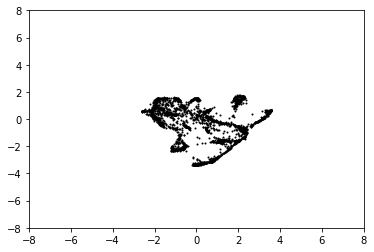

In [13]:
fig, ax = plt.subplots()
ax.scatter(embedding[:,0], embedding[:,1], s=1, color='k', alpha = 1)
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])

### Save

In [14]:
ensure_dir(DATA_DIR / 'embeddings' / DATASET_ID / 'full')

In [15]:
syllable_df.to_pickle(DATA_DIR / 'embeddings' / DATASET_ID / 'full.pickle')